# Dimer energies for molecules with and without LJ parameters on polar hydrogens

In this notebook we intend to compare dimer energies (at varying separations), and potentially forces, for simple hydroxyl-containing molecules with and without LJ parameters on the polar hydrogens. Our goal is to reproduce the "singularity" type effect seen in simulations of such molecules wherein simulations without such parameters crash.

Here we will look initially at dimers of neutral acetic acid and see if we can reproduce the problem.

## Start by loading a reference force field without such LJ parameters, then creating a modified version of it which has such LJ parameters
We use our smirnoff99Frosst force field and create a derivative one with this additional parameter.

Current draft hydrogen LJ parameters come from the `hydrogen_radii.ipynb` file also present in this directory.

In [1]:
from openforcefield.typing.engines.smirnoff import *
import copy
from simtk import unit
import oenotebook as oenb

#What new parameter values will we use?
hydrogen_epsilon = 0.0000527*unit.kilocalorie_per_mole #Additional order of magnitude lower
hydrogen_rminhalf = 0.3*unit.angstrom


# Load original forcefield
old_forcefield = ForceField('forcefield/smirnoff99frosst.ffxml')

# Make a copy
new_forcefield = copy.deepcopy(old_forcefield)

# Retrieve old parameters in question
old_params = old_forcefield.getParameter(smirks = '[#1:1]-[#8]')
new_params = copy.copy(old_params)

# Set new parameters
new_params['epsilon'] = str(hydrogen_epsilon/unit.kilocalorie_per_mole)
new_params['rmin_half'] = str(hydrogen_rminhalf/unit.angstrom)
new_forcefield.setParameter( new_params, smirks = '[#1:1]-[#8]')

# Write out new forcefield to XML
new_forcefield.writeFile('hydrogen_radii.ffxml')

## Next, generate a possible starting structure for acetic acid dimer and visualize result

Requires OpenEye toolkits and [`oeommtools`](https://github.com/oess/oeommtools)

In [2]:
## Next, generate a possible starting structure for acetic acid dimer
from openeye.oechem import *
from openeye.oeomega import *
from openeye.oeiupac import *

# Output data directory
import os
datadir = 'dimer_data'
if not os.path.isdir(datadir): os.mkdir(datadir)

### Generate OEMol for acetic acid, save an instance of the monomer
monomer = OEMol()
OEParseIUPACName(monomer, 'acetic acid')
OEAddExplicitHydrogens(monomer)
OETriposAtomNames(monomer)
omega = OEOmega()
omega.SetMaxConfs(1)
omega(monomer)

### Create a second acetic acid and translate
mol = OEMol(monomer)
#Move one of the molecules over so they're not on top of each other initially - translate by 6A (guess)
coords = mol.GetCoords() # Dictionary by atom, where each set is a tuple in units of angstroms
transldist = -4
for atidx in coords:
    coords[atidx] = (coords[atidx][0]+transldist, coords[atidx][1], coords[atidx][2]+transldist)
mol.SetCoords(coords)

### Add two monomers into a combined acetic acid
dimer = OEMol(monomer)
amap, bmap = OEAddMols(dimer, mol)

### Write out results and see whether this is an effective placement
ofile = oemolostream( os.path.join( datadir, 'dimer_separated.mol2'))
OEWriteMolecule(ofile, dimer)
ofile.close()
# Or visualize inline with nglview!
import nglview
import mdtraj
traj = mdtraj.load(os.path.join( datadir, 'dimer_separated.mol2'))
view = nglview.show_mdtraj(traj)
view


/Users/dmobley/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/dmobley/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


NGLWidget()

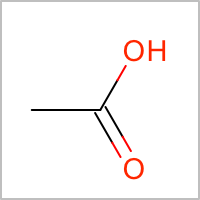

In [3]:
oenb.draw_mol(monomer)

## Energy minimize our dimer and visualize the result

It comes together in a halfway sensible orientation, but does not dimerize as I would expect (can't get to that minima from starting point)


In [4]:
### Use oeommtools to generate a Topology
import oeommtools.utils
topology, coordinates = oeommtools.utils.oemol_to_openmmTop(dimer)
print(monomer.NumAtoms(), topology.getNumAtoms())

### Assign "normal" FF parameters
old_system = old_forcefield.createSystem(topology, [mol], chargeMethod='OECharges_AM1BCCSym')

### Energy minimize
# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = app.Simulation(topology, old_system, integrator)
# Copy in the positions
simulation.context.setPositions( coordinates ) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

### Vizualize result
traj.xyz[0] = np.array(newpositions/unit.nanometer)
view = nglview.show_mdtraj(traj)
view

8 16
Energy before minimization (kcal/mol): -71
Energy after minimization (kcal/mol): -88


NGLWidget()

In [5]:
## Load an alternate starting structure of the dimer from disk
ifile = oemolistream( os.path.join( datadir, 'paired_dimer.mol2'))
dimer = OEMol()
OEReadMolecule(ifile, dimer)
ifile.close()

## Run MD and see what happens

Verdict: If started from the initial offset placement above, it wobbles around but doesn't do anything exciting and doesn't form the dimer one might expect (probably too hard to rotate the hydroxyl torsions from anti to syn).

If started from the dimer, it wobbles around as a dimer but doesn't crash.


In [6]:
# Run MD and see what happens
from mdtraj.reporters import NetCDFReporter
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

# Prep Simulation
simulation = app.Simulation(topology, old_system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
# Set up to write trajectory file to NetCDF file in data directory every 100 frames
netcdf_reporter = NetCDFReporter(os.path.join(datadir, 'trajectory.nc'), 100) #Store every 100 frames
# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(netcdf_reporter)
simulation.reporters.append(app.StateDataReporter(os.path.join(datadir, 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))

# Run the simulation and print start info; store timing
print("Starting simulation")
start = time.clock()
simulation.step(10000) #1000 steps of dynamics
end = time.clock()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds" % (end-start))
netcdf_reporter.close()
print("Done!")

# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
traj= mdtraj.load(os.path.join(datadir, 'trajectory.nc'), top=os.path.join( datadir, 'dimer_separated.mol2'))


# View the trajectory
view = nglview.show_mdtraj(traj)
view

Starting simulation
Elapsed time 1.35 seconds
Done!


/Users/dmobley/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/dmobley/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


NGLWidget(count=100)

# We want to probe the energy landscape as a function of dimer separation

Since normal MD doesn't appear to be probing the landscape that well, let's go ahead and just pull the dimer together directly to see what happens to the energy as a function of separation if we pull on it really hard.

## Bookkeeping: Figure out which atoms to pull together

We'll want to pull the hydroxyl hydrogen in one molecule towards the double-bonded oxygen in the other molecule.
Perhaps, to get better dimer structures, we'll pull both at the same time.  Let's go ahead and figure out what indices these atoms are.

In [7]:
# First loop over topology and identify atoms we want to restrain
# Let's grab the oxygen with only one neighbor in the first molecule and the polar hydrogen in the second, and the
# same for the other pair
hydrogen_idxs = []
oxygen_idxs = []
for idx, atom in enumerate(dimer.GetAtoms()):
    # Check if this is the oxygen we want
    if atom.IsOxygen():
        for bond in atom.GetBonds():
            if bond.GetOrder()==2 and bond.GetNbr(atom).IsCarbon():
                oxygen_idxs.append( idx )
                continue
                
    # Check if this is the hydrogen we want
    if atom.IsHydrogen():
        for bond in atom.GetBonds():
            if bond.GetNbr(atom).IsOxygen():
                hydrogen_idxs.append( idx )
                continue
print(oxygen_idxs, hydrogen_idxs)

[2, 10] [7, 15]


## Next go ahead and energy minimize with restraints ("CustomBondForce") of selected strength

This will allow us to pull them together considerably as we vary the restraint strength.

Note: To get a good structure of the dimer, I energy minimized (via the code below) using a force constant of 10000 between both pairs of atoms and then turned off the restraints, energy minimized again, and dumped the resulting structure via
```python
# Dump dimer
coords = dimer.GetCoords() # Dictionary by atom, where each set is a tuple in units of angstroms
for atidx in coords:
    coords[atidx] = (newpositions[atidx][0]/unit.angstroms, newpositions[atidx][1]/unit.angstroms, newpositions[atidx][2]/unit.angstroms)
dimer.SetCoords(coords)
ofile = oemolostream( os.path.join( datadir, 'paired_dimer.mol2'))
OEWriteMolecule(ofile, dimer)
ofile.close()
```
This allows us to start the restraining procedure below from a dimerized structure and just monitor the energy/separation as we vary the restraint strength.



In [8]:
def initialize_restrained_simulation( topology, coordinates, mol, force_constants, oxygen_idxs, hydrogen_idxs, forcefield):
    ## Initialize a `simulation` with the specified topology, coordinates, component molecule
    # and restraints with the specified force constants (list) between the appropriate pairs of oxygen_idxs and hydrogen_idxs
    # Uses provided forcefield (SMIRNOFF ForceField object)
    
    # Returns bond1, bond2, system, simulation: The indices of the two bonds added, as well as the initialized `simulation`
    
    # Create system again, to allow doing this repeatedly
    system = forcefield.createSystem(topology, [mol], chargeMethod='OECharges_AM1BCCSym')


    #Following http://www.maccallumlab.org/news/2015/1/23/testing
    flat_bottom_force = openmm.CustomBondForce( 'step(r-r0) * (k/2) * (r-r0)^2')
    flat_bottom_force.addPerBondParameter('r0')
    flat_bottom_force.addPerBondParameter('k')
    system.addForce(flat_bottom_force)

    # Set up custom bonds with specified force constant
    r0 = 0.
    bond1 = flat_bottom_force.addBond( oxygen_idxs[0], hydrogen_idxs[1], [r0, force_constants[0]])
    bond2 = flat_bottom_force.addBond( oxygen_idxs[1], hydrogen_idxs[0], [r0, force_constants[1]])


    # Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
    integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
    # Prep the Simulation using the parameterized system, the integrator, and the topology
    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions( coordinates )

    return bond1, bond2, system, simulation

#Apply
bond1, bond2, system, simulation = initialize_restrained_simulation( topology, newpositions, mol, [1000,0], oxygen_idxs, hydrogen_idxs, old_forcefield)

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

### Vizualize result
traj.xyz[0] = np.array(newpositions/unit.nanometer)
view = nglview.show_mdtraj(traj)
view

Energy before minimization (kcal/mol): -24
Energy after minimization (kcal/mol): -85


NGLWidget(count=100)

## Probe energy landscape as a function of dimer separation

Here we'll look at the energy landscape as a function of dimer separation by varying the restraint strength and minimizing repeatedly at different restraint strengths. To ensure we aren't deforming the system we'll minimize with only one restraint (between one hydrogen and one oxygen). Our procedure will be, for each minimization:
- Start with a clean structure of a minimized dimer (minimized with no restraints)
- Add specified restraint
- Energy minimize
- Remove restraint and re-evaluate the energy (without re-minimizing) to get the energy without the restraint
- Store H-O separation and energy

### Define a utility function to return energy of a simulation without restraints

We need to be able to turn off the restraints and get the energy; define a utility function to do that

In [9]:
def energy_without_restraints( system, topology, coordinates, bond_idxs, oxygen_idxs, hydrogen_idxs):
    for force in system.getForces():
        if isinstance(force, openmm.CustomBondForce):
            force.setBondParameters( bond_idxs[0], oxygen_idxs[0], hydrogen_idxs[1], [0,0])
            force.setBondParameters( bond_idxs[1], oxygen_idxs[1], hydrogen_idxs[0], [0,0])
            # Evaluate energy
            integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
            simulation = app.Simulation(topology, system, integrator)
            simulation.context.setPositions( newpositions )
            state = simulation.context.getState(getEnergy = True)
            energy = state.getPotentialEnergy() / unit.kilocalories_per_mole

            return energy

### Go ahead and do analysis of energy as a function of separation

In [10]:
# Pick what restraint values to use
restraint_values = [2**i for i in range(0, 25)]
#restraint_values = [10**i for i in range(2, 5)]
#print(restraint_values)

# Load clean structure of a minimized dimer (minimized with no restraints)
ifile = oemolistream( os.path.join( datadir, 'paired_dimer.mol2'))
dimer = OEMol()
OEReadMolecule(ifile, dimer)
ifile.close()
import openforcefield.utils
dimer_coordinates = openforcefield.utils.extractPositionsFromOEMol(dimer)

# Set up storage for data
separations = []
final_energies = []

# Loop over restraint values and do our analysis
for rval in restraint_values:
    # Add specified restraint
    bond1, bond2, system, simulation = initialize_restrained_simulation( topology, dimer_coordinates, mol, [rval,0],\
                                                                oxygen_idxs, hydrogen_idxs, old_forcefield)

    # Energy minimize
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    print("Energy after minimization (kcal/mol): %.2g" % energy)
    newpositions = state.getPositions()

    # Remove restraint and re-evaluate the energy (without re-minimizing) to get the energy without the restraint
    newenergy = energy_without_restraints( system, topology, newpositions, [bond1, bond2], oxygen_idxs, hydrogen_idxs)
    print("Energy without restraints (kcal/mol): %.2g" % energy)
    
    # Compute H-O separation
    ox_pos = newpositions[oxygen_idxs[0]]
    hyd_pos = newpositions[hydrogen_idxs[1]]
    diff = ox_pos - hyd_pos
    distance = np.sqrt(np.dot(diff,diff))/unit.angstroms
    
    # Store H-O separation and energy
    final_energies.append( newenergy )
    separations.append(distance)


Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -87
Energy without restraints (kcal/mol): -87
Energy after minimization (kcal/mol): -85
Energy without restraints (kcal/mol): -85
Energy after minimization (kcal/mol): -82
Energy without restraints (kcal/mo

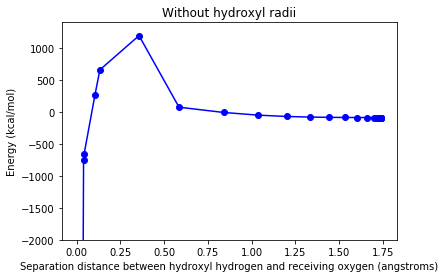

In [11]:
# Graph results
% matplotlib inline
from pylab import *

sortres = sorted(zip(separations,final_energies))
separations = [elem[0] for elem in sortres]
final_energies = [elem[1] for elem in sortres]

figure()
plot( separations, final_energies, 'bo-')
xlabel('Separation distance between hydroxyl hydrogen and receiving oxygen (angstroms)')
ylabel('Energy (kcal/mol)')
title("Without hydroxyl radii")
ylim(-2000, 1.4e3)
show()

### Do the same for our new, modified forcefield

In [12]:
# Pick what restraint values to use
restraint_values = [2**i for i in range(0, 23)]
#restraint_values = [10**i for i in range(2, 5)]
#print(restraint_values)

# Load clean structure of a minimized dimer (minimized with no restraints)
ifile = oemolistream( os.path.join( datadir, 'paired_dimer.mol2'))
dimer = OEMol()
OEReadMolecule(ifile, dimer)
ifile.close()
import openforcefield.utils
dimer_coordinates = openforcefield.utils.extractPositionsFromOEMol(dimer)

# Set up storage for data
new_separations = []
new_final_energies = []

# Loop over restraint values and do our analysis
for rval in restraint_values:
    # Add specified restraint
    bond1, bond2, system, simulation = initialize_restrained_simulation( topology, dimer_coordinates, mol, [rval,0],\
                                                                oxygen_idxs, hydrogen_idxs, new_forcefield)

    # Energy minimize
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    print("Energy after minimization (kcal/mol): %.2g" % energy)
    newpositions = state.getPositions()

    # Remove restraint and re-evaluate the energy (without re-minimizing) to get the energy without the restraint
    newenergy = energy_without_restraints( system, topology, newpositions, [bond1, bond2], oxygen_idxs, hydrogen_idxs)
    print("Energy without restraints (kcal/mol): %.2g" % energy)
    
    # Compute H-O separation
    ox_pos = newpositions[oxygen_idxs[0]]
    hyd_pos = newpositions[hydrogen_idxs[1]]
    diff = ox_pos - hyd_pos
    distance = np.sqrt(np.dot(diff,diff))/unit.angstroms
    
    # Store H-O separation and energy
    new_final_energies.append( newenergy )
    new_separations.append(distance)



Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -88
Energy without restraints (kcal/mol): -88
Energy after minimization (kcal/mol): -87
Energy without restraints (kcal/mol): -87
Energy after minimization (kcal/mol): -85
Energy without restraints (kcal/mol): -85
Energy after minimization (kcal/mol): -82
Energy without restraints (kcal/mo

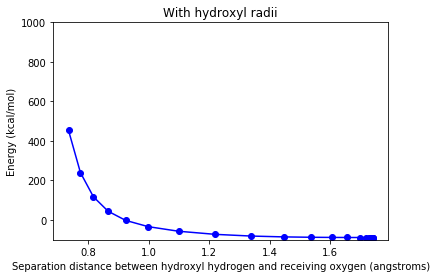

In [14]:
# Graph results
% matplotlib inline
from pylab import *

figure()
title("With hydroxyl radii")
plot( new_separations, new_final_energies, 'bo-')
xlabel('Separation distance between hydroxyl hydrogen and receiving oxygen (angstroms)')
ylabel('Energy (kcal/mol)')
ylim(-100, 1000)
show()